# Evolution of shooting on scoring in the NBA
### Brayden Butt, Watson Li, Frayan Foroughi

In [119]:
# imports
import re
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import PowerNorm
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# https://www.kaggle.com/datasets/mexwell/nba-shots
# 27 foot 4pt line
# 22 foot(corners)
# 23.75 3pt line

# Exclude 2012, 2020 and 2021 for shorter seasons
files = ['data/NBA_2005_Shots.csv', 'data/NBA_2006_Shots.csv', 'data/NBA_2007_Shots.csv', 'data/NBA_2008_Shots.csv', 
         'data/NBA_2009_Shots.csv', 'data/NBA_2010_Shots.csv', 'data/NBA_2011_Shots.csv', 'data/NBA_2012_Shots.csv',
         'data/NBA_2013_Shots.csv', 'data/NBA_2014_Shots.csv', 'data/NBA_2015_Shots.csv', 'data/NBA_2016_Shots.csv', 
         'data/NBA_2017_Shots.csv', 'data/NBA_2018_Shots.csv', 'data/NBA_2019_Shots.csv', 'data/NBA_2020_Shots.csv',
         'data/NBA_2021_Shots.csv', 'data/NBA_2022_Shots.csv', 'data/NBA_2023_Shots.csv', 'data/NBA_2024_Shots.csv'
         ]

# Load in 2004 data as original dataframe
shots_log = pd.read_csv('data/NBA_2004_Shots.csv')
shots_df = pd.DataFrame(shots_log)
# Only keep relevant columns
shots_df = shots_df[['GAME_ID', 'SEASON_1', 'TEAM_NAME',
                      'SHOT_MADE', 'SHOT_TYPE', 'LOC_X',
                      'LOC_Y', 'SHOT_DISTANCE', 'MINS_LEFT', 'SECS_LEFT']]

# Change old team names to new
shots_df['TEAM_NAME'] = shots_df['TEAM_NAME'].replace({'New Jersey Nets': 'Brooklyn Nets', 
                                                    'Charlotte Bobcats': 'Charlotte Hornets',
                                                    'New Orleans Hornets': 'New Orleans Pelicans',
                                                    'New Orleans/Oklahoma City Hornets': 'New Orleans Pelicans',
                                                    'Seattle SuperSonics': 'Oklahoma City Thunder',
                                                    'LA Clippers': 'Los Angeles Clippers'})

# Apply changes to each file from 2005-2024
for file in files:
    temp_file = pd.read_csv(file)
    temp_df = pd.DataFrame(temp_file)
    temp_df = temp_df[['GAME_ID', 'SEASON_1', 'TEAM_NAME',
                      'SHOT_MADE', 'SHOT_TYPE', 'LOC_X',
                      'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 
                      'MINS_LEFT', 'SECS_LEFT']]
    temp_df['TEAM_NAME'] = temp_df['TEAM_NAME'].replace({'New Jersey Nets': 'Brooklyn Nets', 
                                                    'Charlotte Bobcats': 'Charlotte Hornets',
                                                    'New Orleans Hornets': 'New Orleans Pelicans',
                                                    'New Orleans/Oklahoma City Hornets': 'New Orleans Pelicans',
                                                    'Seattle SuperSonics': 'Oklahoma City Thunder',
                                                    'LA Clippers': 'Los Angeles Clippers'})
    # Combine the dataframes with each other
    shots_df = pd.concat([shots_df, temp_df])

# add a column to our shots dataframe to indicate whether a shot was a 4pt attempt
shots_df['FOUR_PT_ATTEMPT'] = (shots_df['SHOT_DISTANCE'] > 27).astype(int)

# Create new columns for 2-pt and 3-pt attempts
shots_df['FG2A'] = (shots_df['SHOT_TYPE'] == '2PT Field Goal').astype(int)
shots_df['FG3A'] = (shots_df['SHOT_TYPE'] == '3PT Field Goal').astype(int)

# Create separate dataframe with free throw numbers
free_throws = pd.read_csv('data/NBA_2023_2024_Stats.csv')

In [121]:
# assertions to ensure data is clean
# no NA values in important columns
assert not shots_df['TEAM_NAME'].isna().any(), "Missing team names"
assert not shots_df['SHOT_MADE'].isna().any(), "Missing shot made values"

# shot distance within expected range (0, 94)
assert 0 <= shots_df['SHOT_DISTANCE'].min() <= 94, f"SHOT_DISTANCE out of range: min={shots_df['SHOT_DISTANCE'].min()}"
assert 0 <= shots_df['SHOT_DISTANCE'].max() <= 94, f"SHOT_DISTANCE out of range: max={shots_df['SHOT_DISTANCE'].max()}"

# LOC_X within expected range (-25, 25)
assert -25 <= shots_df['LOC_X'].min() <= 25, f"LOC_X out of range: min={shots_df['LOC_X'].min()}"
assert -25 <= shots_df['LOC_X'].max() <= 25, f"LOC_X out of range: max={shots_df['LOC_X'].max()}"

# LOC_Y within expected range (0, 94)
assert 0 <= shots_df['LOC_Y'].min() <= 94, f"LOC_Y out of range: min={shots_df['LOC_Y'].min()}"
assert 0 <= shots_df['LOC_Y'].max() <= 94, f"LOC_Y out of range: max={shots_df['LOC_Y'].max()}"

In [ ]:
# Data from https://www.kaggle.com/datasets/amanuelwk/nba-regular-season-data/data
filesDetailed =    ['data/season_1981_detailed.csv', 'data/season_1982_detailed.csv', 'data/season_1983_detailed.csv',
                    'data/season_1984_detailed.csv', 'data/season_1985_detailed.csv', 'data/season_1986_detailed.csv',
                    'data/season_1987_detailed.csv', 'data/season_1988_detailed.csv', 'data/season_1989_detailed.csv', 
                    'data/season_1990_detailed.csv', 'data/season_1991_detailed.csv', 'data/season_1992_detailed.csv', 
                    'data/season_1993_detailed.csv', 'data/season_1994_detailed.csv', 'data/season_1995_detailed.csv', 
                    'data/season_1996_detailed.csv', 'data/season_1997_detailed.csv', 'data/season_1998_detailed.csv',
                    'data/season_2000_detailed.csv', 'data/season_2001_detailed.csv', 'data/season_2002_detailed.csv', 
                    'data/season_2003_detailed.csv'
                    ]

# Create dataframe for finding three point goals
fg_attempts = pd.read_csv('data/season_1980_detailed.csv')
fg_attempts = pd.DataFrame(fg_attempts)
# Filter out all non-important columns
fg_attempts['season'] = 1980
fg_attempts['FG2A'] = fg_attempts['FGA'] - fg_attempts['FG3A']
fg_attempts = fg_attempts[['season', 'FG3A', 'FG2A']]

# Added the rest of the data files together
for data in filesDetailed:
    tempFile = pd.read_csv(data)
    temporary_df = pd.DataFrame(tempFile)
    temporary_df['season'] = re.search(r'(\d{4})', data).group(1)
    temporary_df['FG2A'] = temporary_df['FGA'] - temporary_df['FG3A']
    temporary_df = temporary_df[['season', 'FG3A', 'FG2A']]
    # Combine the dataframes with eachother
    fg_attempts = pd.concat([fg_attempts, temporary_df])

# Copy shots_df to gather FGA information
fg_attempts2 = shots_df.copy()

# Combine FGA data from 1980-2024 into singular dataframe
fg_attempts2 = (
    fg_attempts2.groupby('SEASON_1', as_index=False)[['FG2A', 'FG3A']]
    .sum()
)
fg_attempts = (
    fg_attempts.groupby('season', as_index=False)[['FG2A', 'FG3A']]
    .sum()
)
fg_attempts2.rename(columns={'SEASON_1': 'season'}, inplace=True)
fg_attempts = pd.concat([fg_attempts, fg_attempts2])

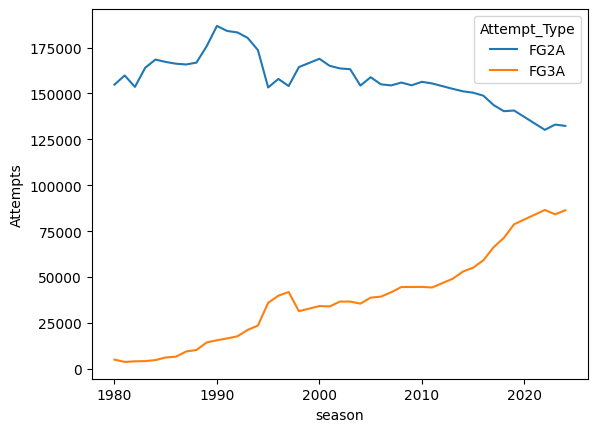

In [ ]:
# Plot 2PT and 3PT attempts from 1980-2024
fg_attempts_melted = fg_attempts.melt(id_vars=['season'], value_vars=['FG2A', 'FG3A'], 
                                      var_name='Attempt_Type', value_name='Attempts')

# drop years 1999, 2011, 2020, 2021 due to shorter seasons
fg_attempts_melted = fg_attempts_melted[~fg_attempts_melted['season'].isin([1999, 2012, 2020, 2021])]
sns.lineplot(data=fg_attempts_melted, x='season', y='Attempts', hue='Attempt_Type')
plt.show()

In [124]:
# Split the seasons into half-decades
fg_attempts['season'] = pd.to_numeric(fg_attempts['season'], errors='coerce')
fg_attempts['half_decade'] = (fg_attempts['season'] // 5) * 5

# Group FG3A values by half-decades
groups = fg_attempts.groupby('half_decade')['FG3A'].apply(list)
half_decade_ranges = [f"{year}-{year + 4}" for year in groups.index]

fg_attempts.loc[fg_attempts['season'] >= 2021, 'half_decade'] = 2021

# Perform t-tests between each half-decade
results = []
for i in range(len(groups) - 1):
    half_decade_1 = half_decade_ranges[i]
    half_decade_2 = half_decade_ranges[i + 1]
    group1 = pd.to_numeric(groups.iloc[i], errors='coerce')
    group2 = pd.to_numeric(groups.iloc[i + 1], errors='coerce')
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
    is_significant = p_value < 0.05
    results.append({
        'half_decade_1': half_decade_1,
        'half_decade_2': half_decade_2,
        't_stat': t_stat,
        'p_value': p_value,
        'significance': is_significant
    })

result_df = pd.DataFrame(results)

# Print the p-values and show significance
for _, row in result_df.iterrows():
    if row['significance']:
        print(f"Comparison between {row['half_decade_1']} and {row['half_decade_2']}: Significant difference (p = {row['p_value']:.4f})")
    else:
        print(f"Comparison between {row['half_decade_1']} and {row['half_decade_2']}: No significant difference (p = {row['p_value']:.4f})")

Comparison between 1980-1984 and 1985-1989: Significant difference (p = 0.0265)
Comparison between 1985-1989 and 1990-1994: Significant difference (p = 0.0019)
Comparison between 1990-1994 and 1995-1999: Significant difference (p = 0.0009)
Comparison between 1995-1999 and 2000-2004: No significant difference (p = 0.4830)
Comparison between 2000-2004 and 2005-2009: Significant difference (p = 0.0040)
Comparison between 2005-2009 and 2010-2014: No significant difference (p = 0.2744)
Comparison between 2010-2014 and 2015-2019: Significant difference (p = 0.0048)
Comparison between 2015-2019 and 2020-2024: Significant difference (p = 0.0245)


In [125]:
success_rate = shots_df[shots_df['SEASON_1'] == 2024].copy()

success_rate.loc[:, 'FG2M'] = ((success_rate['SHOT_MADE'] == True) & (success_rate['FG2A'] == 1)).astype(int)
success_rate.loc[:, 'FG3M'] = ((success_rate['SHOT_MADE'] == True) & (success_rate['FG3A'] == 1)).astype(int)
success_rate.loc[:, 'FG4M'] = ((success_rate['SHOT_MADE'] == True) & (success_rate['FOUR_PT_ATTEMPT'] == 1)).astype(int)

# avoid double counting 4pt attempts as 3pt attempts
success_rate.loc[success_rate['FOUR_PT_ATTEMPT'] == 1, 'FG3A'] = 0
success_rate.loc[success_rate['FOUR_PT_ATTEMPT'] == 1, 'FG3M'] = 0

success_rate = success_rate[['GAME_ID', 'FOUR_PT_ATTEMPT', 'FG2A', 'FG3A', 'FG2M', 'FG3M', 'FG4M']]
success_rate = (success_rate.groupby('GAME_ID', as_index=False).sum())

# print(success_rate)

In [126]:
success_rate['FG2_percent'] = success_rate['FG2M']/success_rate['FG2A']
success_rate['FG3_percent'] = success_rate['FG3M']/success_rate['FG3A']
success_rate['FG4_percent'] = success_rate['FG4M']/success_rate['FOUR_PT_ATTEMPT']

sim_data = {
    'FT_attempts': [free_throws['Free_Throws_Attempted'].mean()],
    'FG2_attempts': [success_rate['FG2A'].mean()],
    'FG3_attempts': [success_rate['FG3A'].mean()],
    'FG4_attempts': [success_rate['FOUR_PT_ATTEMPT'].mean()],
    'FT_made': [free_throws['Free_Throws'].mean()],
    'FG2_made': [success_rate['FG2M'].mean()],
    'FG3_made': [success_rate['FG3M'].mean()],
    'FG4_made': [success_rate['FG4M'].mean()],
    'FT_avg': [free_throws['Free_Throw_Percentage'].mean()],
    'FG2_avg': [success_rate['FG2_percent'].mean()],
    'FG3_avg': [success_rate['FG3_percent'].mean()],
    'FG4_avg': [success_rate['FG4_percent'].mean()]
}

# Convert the dictionary to a dataframe
sim_data_df = pd.DataFrame(sim_data)

print(sim_data_df)
# Number of games to simulate
games = 82 

# Extract the values from the dataframe
ft_attempts = sim_data_df['FT_attempts'].values[0]
fg2_attempts = sim_data_df['FG2_attempts'].values[0]
fg3_attempts = sim_data_df['FG3_attempts'].values[0]
fg4_attempts = sim_data_df['FG4_attempts'].values[0]
ft_avg = sim_data_df['FT_avg'].values[0]
fg2_avg = sim_data_df['FG2_avg'].values[0]
fg3_avg = sim_data_df['FG3_avg'].values[0]
fg4_avg = sim_data_df['FG4_avg'].values[0]
 
#print the values
print(ft_attempts, fg2_attempts, fg3_attempts, fg4_attempts, ft_avg, fg2_avg, fg3_avg, fg4_avg)

simulated_scores = []

np.random.seed(353)
for game in range(games):
    # Simulate the number of shots made using binomial distribution
    # then divide by 2 as each game has 2 teams
    ft_made = np.random.binomial(n=ft_attempts, p=ft_avg) / 2
    fg2_made = np.random.binomial(n=fg2_attempts, p=fg2_avg) / 2
    fg3_made = np.random.binomial(n=fg3_attempts, p=fg3_avg) / 2
    fg4_made = np.random.binomial(n=fg4_attempts, p=fg4_avg) / 2
    
    # Calculate the total points scored in this game
    total_points = (ft_made * 1) + (fg2_made * 2) + (fg3_made * 3) + (fg4_made * 4)
    
    # Append the result to the list
    simulated_scores.append(total_points)

# Convert to dataframe
simulated_scores_df = pd.DataFrame(simulated_scores, columns=['Total_Points'])

print(simulated_scores_df.mean())

   FT_attempts  FG2_attempts  FG3_attempts  FG4_attempts    FT_made  \
0     93.57268    107.598374     64.686179      5.521138  73.385289   

    FG2_made   FG3_made  FG4_made   FT_avg   FG2_avg   FG3_avg   FG4_avg  
0  58.666667  24.002439  1.671545  0.74711  0.545331  0.370902  0.284004  
93.57267950963222 107.59837398373983 64.68617886178862 5.521138211382114 0.7471098696461824 0.545331273356568 0.37090234838552827 0.28400402298765925
Total_Points    132.152439
dtype: float64


In [127]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    '''
    adapted from http://savvastjortjoglou.com/nba-shot-sharts.html
    scaling and plotting was modified to fit our plot, 
    and a four-point line was added
    '''
    if ax is None:
        ax = plt.gca()
        
    # center the court
    court_center_x = 0
    court_center_y = 4.75
    
    # make hoop
    hoop = Circle((court_center_x, court_center_y), radius=0.75, linewidth=lw, color=color, fill=False)
    
    # make backboard
    backboard = Rectangle((court_center_x - 3, court_center_y - 0.75), 6, -0.1, linewidth=lw, color=color)
    
    outer_box = Rectangle((court_center_x - 8, court_center_y - 4.75), 16, 19, linewidth=lw, color=color, fill=False)
    inner_box = Rectangle((court_center_x - 6, court_center_y - 4.75), 12, 19, linewidth=lw, color=color, fill=False)
    
    # top of the key
    top_free_throw = Arc((court_center_x, court_center_y + 14.25), 12, 12, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((court_center_x, court_center_y + 14.25), 12, 12, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    
    # restricted zone
    restricted = Arc((court_center_x, court_center_y), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color)
    
    # 3pt line
    corner_three_a = Rectangle((court_center_x - 22, court_center_y - 4.75), 0, 14, linewidth=lw, color=color)
    corner_three_b = Rectangle((court_center_x + 22, court_center_y - 4.75), 0, 14, linewidth=lw, color=color)
    three_arc = Arc((court_center_x, court_center_y), 47.5, 47.5, theta1=22, theta2=158, linewidth=lw, color=color)
    
    # our new 4pt line
    four_arc = Arc((court_center_x, court_center_y), 54, 54, theta1=0, theta2=180, linewidth=lw, color='red')

    # center court
    center_outer_arc = Arc((court_center_x, court_center_y + 42.25), 12, 12, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((court_center_x, court_center_y + 42.25), 4, 4, theta1=180, theta2=0, linewidth=lw, color=color)
    
    # elements to be plotted
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw, 
                     restricted, corner_three_a, corner_three_b, three_arc, four_arc, center_outer_arc, center_inner_arc]
    
    if outer_lines:
        # draw the outer lines
        outer_lines = Rectangle((court_center_x - 25, court_center_y - 4.75), 50, 47, linewidth=lw, color=color, fill=False)  # 250,47.5,500,470 * 0.1
        court_elements.append(outer_lines)
    
    # plot the linsted elements
    for element in court_elements:
        ax.add_patch(element)
        
    return ax

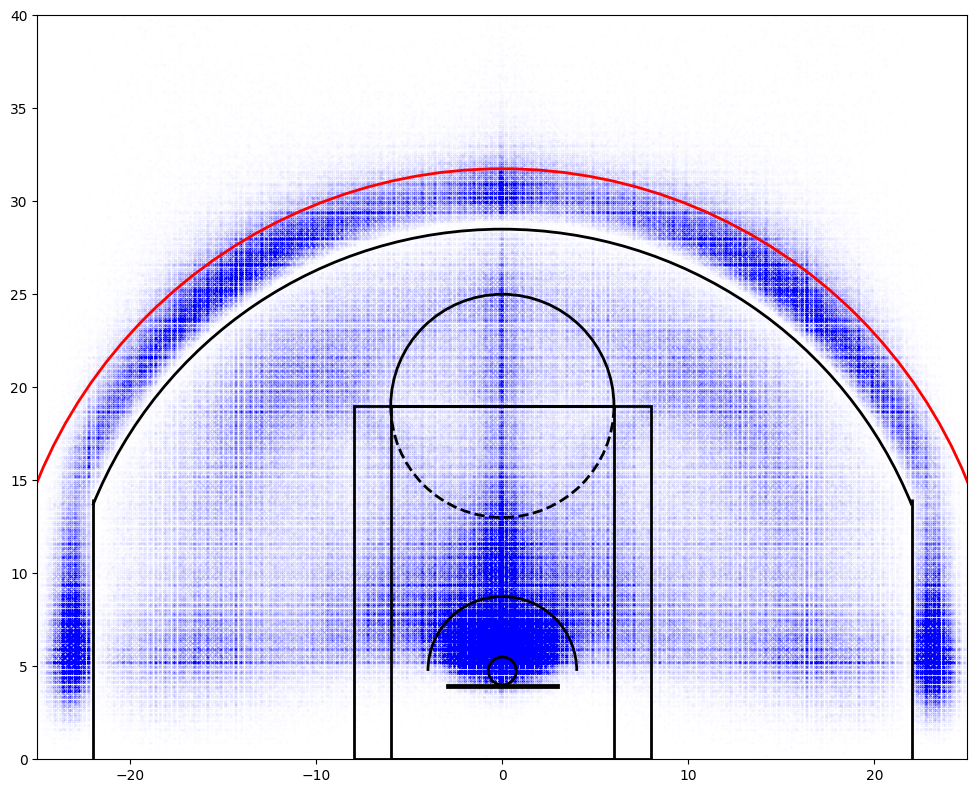

In [128]:
# heatmap of shots, 2004-2024

fig, ax = plt.subplots(figsize=(12, 12))

no_bad_years = shots_df[~shots_df['SEASON_1'].isin([2020, 2021, 2022])]

# scatter plot of shots
ax.scatter(no_bad_years['LOC_X'], no_bad_years['LOC_Y'], color='blue', alpha=0.005, s=2)  # if the alpha and size are any higher, it's just a sea of blue

# court atop the scatter plot so we can see the lines
draw_court(ax)

ax.set_xlim(-25, 25)
ax.set_ylim(0, 40)

ax.set_aspect('equal', adjustable='box')

plt.show()

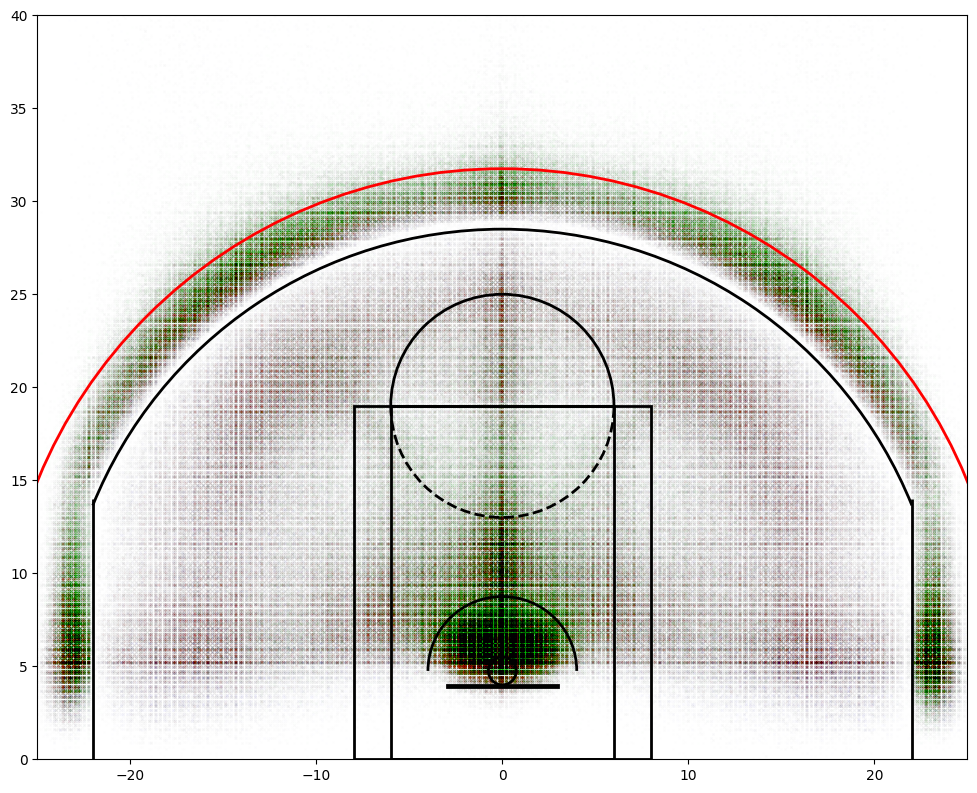

In [129]:
# another scatter plot, color coded by season
# heatmap of shots, 2004-2024

fig, ax = plt.subplots(figsize=(12, 12))

no_bad_years = shots_df[~shots_df['SEASON_1'].isin([2020, 2021, 2022])]

# setting up color coding
unique_seasons = no_bad_years['SEASON_1'].unique()
cmap = plt.colormaps['brg'](np.linspace(0, 1, len(unique_seasons))) 
# can't find a good colormap for this, so I'm using brg
# looked across https://matplotlib.org/stable/users/explain/colors/colormaps.html
# another half-decent one was tab20 but really they're all hideous

# scatter plot of shots
# REDDER SHOTS ARE OLDER;
# GREENER SHOTS ARE NEWER
for i, season in enumerate(unique_seasons):
    season_data = no_bad_years[no_bad_years['SEASON_1'] == season]
    ax.scatter(season_data['LOC_X'], season_data['LOC_Y'], color=cmap[i], alpha=0.005, s=2)
# if the alpha and size are any higher, it's just a sea of blue

# court atop the scatter plot so we can see the lines
draw_court(ax)

ax.set_xlim(-25, 25)
ax.set_ylim(0, 40)

ax.set_aspect('equal', adjustable='box')

plt.show()

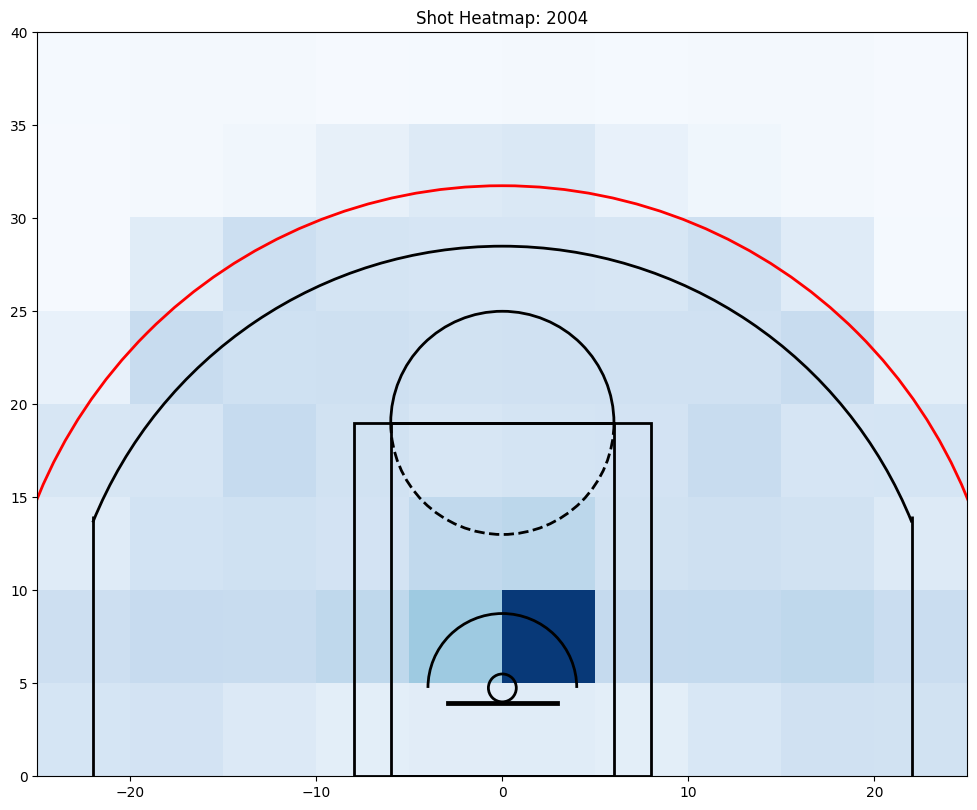

In [130]:
x_min, x_max = -25, 25
y_min, y_max = 0, 40
bin_size = 5

x_bins = np.arange(x_min, x_max + bin_size, bin_size)
y_bins = np.arange(y_min, y_max + bin_size, bin_size)

# get the max shot count for each bin across all seasons, as we'll be normalizing each season's heatmap by this value
heatmap_global = np.zeros((len(x_bins) - 1, len(y_bins) - 1))
for season in no_bad_years['SEASON_1'].unique():
    season_data = no_bad_years[no_bad_years['SEASON_1'] == season]
    heatmap, _, _ = np.histogram2d(season_data['LOC_X'], season_data['LOC_Y'], bins=[x_bins, y_bins])
    heatmap_global = np.maximum(heatmap_global, heatmap)

# helper function to make each frame of the animation
def update(frame):
    ax.clear()
    draw_court(ax)
    season = unique_seasons[frame]
    season_data = no_bad_years[no_bad_years['SEASON_1'] == season]
    heatmap, _, _ = np.histogram2d(season_data['LOC_X'], season_data['LOC_Y'], bins=[x_bins, y_bins])
    
    # normalize heatmap by the global max
    heatmap = heatmap / heatmap_global.max()
    
    # plot heatmap
    ax.imshow(heatmap.T, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='Blues', norm=PowerNorm(gamma=0.5, vmin=0, vmax=1))
    ax.set_title(f"Shot Heatmap: {season}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots(figsize=(12, 12))
unique_seasons = sorted(no_bad_years['SEASON_1'].unique())
ani = FuncAnimation(fig, update, frames=len(unique_seasons), repeat=True)

ani.save('shots_heatmap.gif', writer=PillowWriter(fps=2))

In [ ]:
# for data from 2004-2024:
# number of shots that were attempted from beyond the 3pt line
three_pt_attempts = shots_df[shots_df['SHOT_DISTANCE'] > 23.75]

# shots made from beyond our 4pt line
four_pt_makes = three_pt_attempts[(three_pt_attempts['SHOT_DISTANCE'] > 27) & 
                                  (three_pt_attempts['SHOT_MADE'] == 1)
                                  ]

four_pt_attempts = three_pt_attempts[three_pt_attempts['SHOT_DISTANCE'] > 27]
three_pt_makes = three_pt_attempts[three_pt_attempts['SHOT_MADE'] == 1]

# 4 pt shot stats
if len(three_pt_attempts) > 0:
    three_pt_percentage = len(three_pt_makes) / len(three_pt_attempts)
else:
    three_pt_percentage = 0
if len(four_pt_attempts) > 0:
    four_pt_percentage = len(four_pt_makes) / len(four_pt_attempts)
else:
    four_pt_percentage = 0

print(f'Percentage of 4pt shots made, 2004-2024: {four_pt_percentage * 100:.2f}%')
print(f'Percentage of 3pt shots made, 2004-2024: {three_pt_percentage * 100:.2f}%')
print(f'Successful 4 pt shots as a percentage of successful 3pt shots: {len(four_pt_makes) / len(three_pt_makes) * 100:.2f}%')
print(f'Successful 4 pt shots as a percentage of shots attempted beyond the 3pt line: {len(four_pt_makes) / len(three_pt_attempts) * 100:.2f}%')

Percentage of 4pt shots made, 2004-2024: 23.83%
Percentage of 3pt shots made, 2004-2024: 34.95%
Successful 4 pt shots as a percentage of successful 3pt shots: 4.60%
Successful 4 pt shots as a percentage of shots attempted beyond the 3pt line: 1.61%


In [132]:
shots_24 = shots_df[shots_df['SEASON_1'] == 2024].copy()
# print(shots_24.head())
# see how much scoring would have changed in 2024 if the 4pt line was introduced in 2024

shots_24.loc[:, 'FG2M'] = ((shots_24['FG2A'] == 1) & (shots_24['SHOT_MADE'])).astype(int)
shots_24.loc[:, 'FG3M_OLD'] = ((shots_24['FG3A'] == 1) & (shots_24['SHOT_MADE'])).astype(int)

# reclassify 4pt shots and remove them from 3pt shots
shots_24.loc[shots_24['FOUR_PT_ATTEMPT'] == 1, 'FG3A'] = 0

shots_24.loc[:, 'FG3M_NEW'] = ((shots_24['FG3A'] == 1) & (shots_24['SHOT_MADE'])).astype(int)
shots_24.loc[:, 'FG4M'] = ((shots_24['FOUR_PT_ATTEMPT'] == 1) & (shots_24['SHOT_MADE'])).astype(int)

# group + aggregate data
new_shots_24 = shots_24.groupby(['GAME_ID', 'TEAM_NAME'], as_index=False).agg(FG2M=('FG2M', 'sum'), FG3M_OLD=('FG3M_OLD', 'sum'), FG3M_NEW=('FG3M_NEW', 'sum'), FG4M=('FG4M', 'sum'))
new_shots_24['OLD_TEAM_SCORE'] = (new_shots_24['FG2M'] * 2) + (new_shots_24['FG3M_OLD'] * 3)
new_shots_24['NEW_TEAM_SCORE'] = (new_shots_24['FG2M'] * 2) + (new_shots_24['FG3M_NEW'] * 3) + (new_shots_24['FG4M'] * 4)

# sort by improvement in score, descending
# this is just FG4M, as each 4pt shot is just a 1 pt improvement over a 3pt shot
new_shots_24 = new_shots_24.sort_values('FG4M', ascending=False)

print(new_shots_24.head(5))

# just the teams and the total number of 4pt shots made in 2024
team_fg4m = shots_24.groupby('TEAM_NAME', as_index=False).agg(FG4M=('FG4M', 'sum'))
team_fg4m = team_fg4m.sort_values('FG4M', ascending=False)
print(team_fg4m.head(10))

       GAME_ID              TEAM_NAME  FG2M  FG3M_OLD  FG3M_NEW  FG4M  \
2013  22301007        Milwaukee Bucks    27        16         8     8   
620   22300311   New Orleans Pelicans    34        16         8     8   
1165  22300583       Sacramento Kings    29        15         7     8   
177   22300089     Washington Wizards    24        16         9     7   
1298  22300650  Golden State Warriors    32        23        16     7   

      OLD_TEAM_SCORE  NEW_TEAM_SCORE  
2013             102             110  
620              116             124  
1165             103             111  
177               96             103  
1298             133             140  
                TEAM_NAME  FG4M
9   Golden State Warriors   147
16        Milwaukee Bucks   140
29     Washington Wizards   125
1          Boston Celtics   111
5     Cleveland Cavaliers   102
22     Philadelphia 76ers    91
23           Phoenix Suns    82
13     Los Angeles Lakers    79
11         Indiana Pacers    79
0      

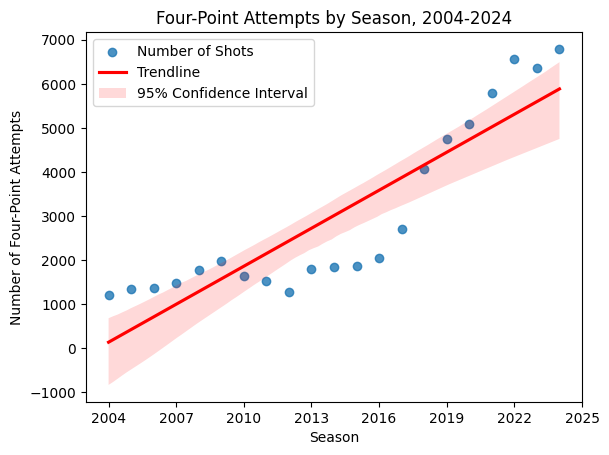

Slope: 287.26753246753253
Intercept: -575545.5722943724
R-squared: 0.7928888854344418
P-value: 6.39615516785873e-08
Standard Error of the Slope: 33.6825746814673


In [133]:
# group by season and sum the number of 4pt attempts
four_pt_attempts_by_season = shots_df.groupby('SEASON_1')['FOUR_PT_ATTEMPT'].sum()
# regression of 4pt attempts by season
p = sns.regplot(data=four_pt_attempts_by_season.reset_index(), x='SEASON_1', y='FOUR_PT_ATTEMPT', marker='o', line_kws={'color': 'red'})
p.set_title('Four-Point Attempts by Season, 2004-2024')
p.set_xlabel('Season')
p.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# legend for the regression line with prediction interval
p.legend(['Number of Shots', 'Trendline', '95% Confidence Interval'])
p.set_ylabel('Number of Four-Point Attempts')
plt.show()
# get our coefficients
slope, intercept, r_value, p_value, std_err = stats.linregress(four_pt_attempts_by_season.index, four_pt_attempts_by_season)
print(f'Slope: {slope}' + '\n' + f'Intercept: {intercept}' + '\n' + f'R-squared: {r_value**2}' + '\n' + f'P-value: {p_value}' + '\n' + f'Standard Error of the Slope: {std_err}')
# slope is definitely non-zero (p-value = 1.346e-06)
# reject the null hypothesis that the number of 4pt attempts is constant over time
# even if we look at the slope with 2 standard errors, 
# we get a bracket of [199.706807, 345.894412], which doesn't include zero

In [134]:
# prediction for a given year, with 2 SE prediction interval
pred_year = 2030

n = len(four_pt_attempts_by_season)
x_mean = np.mean(four_pt_attempts_by_season.index)
resids = four_pt_attempts_by_season - (slope * four_pt_attempts_by_season.index + intercept)
resid_var = np.sum(resids**2) / (n-2)
se_pred = np.sqrt(resid_var * (1 + 1/n + (pred_year - x_mean)**2 / np.sum((four_pt_attempts_by_season.index - x_mean)**2)))
pred = slope * pred_year + intercept
t_val = stats.t.ppf(0.975, n-2)

# the prediction interval
pred_int = t_val * se_pred

print(f'Predicted number of 4pt attempts in {pred_year}: {round(pred)} ± {round(pred_int)}')

Predicted number of 4pt attempts in 2030: 7608 ± 2298


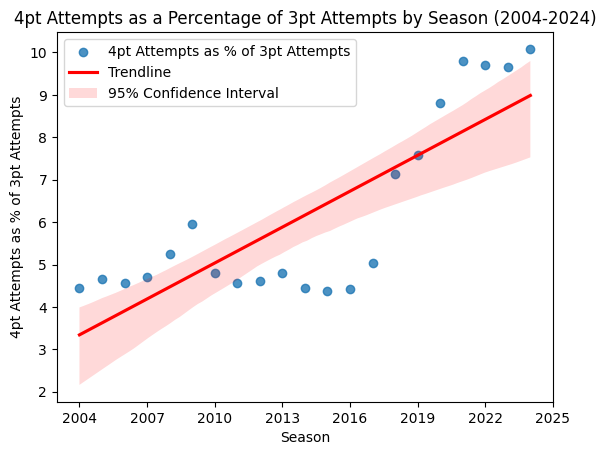

Slope: 0.2822477284898498
Intercept: -562.28248424543
R-squared: 0.6595821937077855
P-value: 7.783869916967911e-06
Standard Error of the Slope: 0.04651845989492217


In [135]:
three_pt_attempts_by_season = shots_df[shots_df['SHOT_DISTANCE'] > 23.75].groupby('SEASON_1').size()
four_pt_attempts_by_season = shots_df.groupby('SEASON_1')['FOUR_PT_ATTEMPT'].sum()
percentage_four_pt_attempts = (four_pt_attempts_by_season / three_pt_attempts_by_season) * 100
percentage_df = percentage_four_pt_attempts.reset_index()
percentage_df.columns = ['SEASON_1', 'Percentage']

p = sns.regplot(data=percentage_df, x='SEASON_1', y='Percentage', marker='o', line_kws={'color': 'red'})
p.set_title('4pt Attempts as a Percentage of 3pt Attempts by Season (2004-2024)')
p.set_xlabel('Season')
p.set_ylabel('4pt Attempts as % of 3pt Attempts')
p.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
p.legend(['4pt Attempts as % of 3pt Attempts', 'Trendline', '95% Confidence Interval'])
plt.show()

slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(percentage_df['SEASON_1'], percentage_df['Percentage'])
print(f'Slope: {slope2}' + '\n' + f'Intercept: {intercept2}' + '\n' + f'R-squared: {r_value2**2}' + '\n' + f'P-value: {p_value2}' + '\n' + f'Standard Error of the Slope: {std_err2}')


In [136]:
# once again, slope is non-zero, with a 95% confidence interval (2SE) of [0.15351373112, 0.35099679569]
# which doesn't include 0, and we can safely say that the number of 4pt attempts as a percentage of 3pt attempts is increasing over time 

# prediction for a given year, with 2 SE prediction interval
n2 = len(percentage_df)
x_mean2 = np.mean(percentage_df['SEASON_1'])
resids2 = percentage_df['Percentage'] - (slope2 * percentage_df['SEASON_1'] + intercept2)
resid_var2 = np.sum(resids2**2) / (n2-2)
se_pred2 = np.sqrt(resid_var2 * (1 + 1/n2 + (pred_year - x_mean2)**2 / np.sum((percentage_df['SEASON_1'] - x_mean2)**2)))
pred2 = slope2 * pred_year + intercept2
t_val2 = stats.t.ppf(0.975, n2-2)

# the prediction interval
pred_int2 = t_val2 * se_pred2

print(f'Predicted 4pt attempts as a Percentage of 3pt attempts in {pred_year}: {round(pred2, 2)}% ± {round(pred_int2, 2)}%')

Predicted 4pt attempts as a Percentage of 3pt attempts in 2030: 10.68% ± 3.17%


In [146]:
no_bad_years.loc[:, 'TIME_LEFT_SECONDS'] = no_bad_years['MINS_LEFT'] * 60 + no_bad_years['SECS_LEFT']
four_pt_shots = no_bad_years[no_bad_years['SHOT_DISTANCE'] > 27]
# KNN to see if we can predict whether a 4pt shot is made or missed, based on SEASON_1, LOC_X, LOC_Y_, and TIME_LEFT_SECONDS

X = four_pt_shots[['SEASON_1', 'LOC_X', 'LOC_Y', 'TIME_LEFT_SECONDS']]
y = four_pt_shots['SHOT_MADE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f'KNN Accuracy: {round(accuracy, 6)* 100}%')
# KNN Accuracy: 0.7431783453394455

KNN Accuracy: 74.3178%
